## Ομάδα #75 
### Νικόλαος Μανιάτης - Φίλιππος Μαυρεπής

##### Datasets: S12,	B04,	119

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import GridSearchCV

**Dataset Abstract**
NASA data set, obtained from a series of aerodynamic and acoustic tests of two and three-dimensional airfoil blade sections conducted in an anechoic wind tunnel.

**Attribute Information:**

This problem has the following inputs:
1. Frequency, in Hertzs.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:
6. Scaled sound pressure level, in decibels.

In [49]:
features = ['freq','angle','length','velocity','thickness','pressure']
df = pd.read_table('./datasets/airfoil_self_noise.dat',names = features )
print(df.shape)
df.head()

(1503, 6)


,freq,angle,length,velocity,thickness,pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [50]:
df.isna().sum()

freq         0
angle        0
length       0
velocity     0
thickness    0
pressure     0
dtype: int64

In [51]:
df.corr()

,freq,angle,length,velocity,thickness,pressure
freq,1.000000,-0.272765,-0.003661,0.133664,-0.230107,-0.390711
angle,-0.272765,1.000000,-0.504868,0.058760,0.753394,-0.156108
length,-0.003661,-0.504868,1.000000,0.003787,-0.220842,-0.236162
velocity,0.133664,0.058760,0.003787,1.000000,-0.003974,0.125103
thickness,-0.230107,0.753394,-0.220842,-0.003974,1.000000,-0.312670
pressure,-0.390711,-0.156108,-0.236162,0.125103,-0.312670,1.000000


In [52]:
df.columns

Index(['freq', 'angle', 'length', 'velocity', 'thickness', 'pressure'], dtype='object')

### Variance Inflation Factor

In [68]:
# VIF dataframe 
vif_data = df.copy()
vif_data = vif_data.drop(['pressure'],axis=1)
# calculating VIF for each feature 
x = [variance_inflation_factor(vif_data.values, i) 
                          for i in range(len(vif_data.columns))] 
  
x

[1.9426267545705205,
 6.557489390964019,
 3.2544472087129486,
 7.148723394340726,
 4.299617241817291]

### Train-Test-Split our Dataset

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
X = df.copy()
X = X.drop(['pressure'],axis=1)
y = df[['pressure']]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=75)
print('X train shape:',X_train.shape)
print('X test shape:',X_test.shape)
print('y train shape:',y_train.shape)
print('y test shape:',y_test.shape)

X train shape: (1052, 5)
X test shape: (451, 5)
y train shape: (1052, 1)
y test shape: (451, 1)


## Ordinary Least Squares

In [91]:
from sklearn.linear_model import LinearRegression

In [92]:
reg = LinearRegression().fit(X_train, y_train)

In [93]:
reg.score(X_test, y_test)

0.48701529018157896

#### Recursive Feature Elimination

In [75]:
from sklearn.feature_selection import RFE

In [94]:
selector = RFE(reg, n_features_to_select=4, step=1,verbose=2)
selector = selector.fit(X_train, y_train)
print(selector.support_)
print(selector.ranking_)

Fitting estimator with 5 features.
[False  True  True  True  True]
[2 1 1 1 1]


## Polynomial Regression

In [96]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly = PolynomialFeatures(degree=2)
poly.fit_transform(X)

In [97]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
...                   ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data
model = model.fit(X_train,y_train)
model.named_steps['linear'].coef_
model.score(X_test, y_test)

array([[ 1.34191237e+02, -6.96105653e-04, -7.17269223e-01,
        -5.49112382e+01,  1.39288356e-02,  2.44134759e+02,
         1.88712874e-08,  5.11438929e-06, -4.96012099e-03,
         3.69145096e-06, -5.99579119e-02,  2.21634040e-02,
         4.23093105e+00, -3.79178176e-03, -2.39154453e+01,
         8.65395567e+01,  1.57170459e-01, -2.40129738e+03,
         3.21940787e-04,  3.61475338e+00,  1.89633638e+03]])

In [106]:
for i in range(1,4):
    model = Pipeline([('poly', PolynomialFeatures(degree=i)),
    ('linear', LinearRegression(fit_intercept=False))])
    # fit to an order-3 polynomial data
    model = model.fit(X_train,y_train)
    model.named_steps['linear'].coef_
    print('degree of polynomial = {} and score is {}'.format(i,model.score(X_test, y_test)))

degree of polynomial = 1 and score is 0.48701529018065437
degree of polynomial = 2 and score is 0.6223336446282258
degree of polynomial = 3 and score is 0.7209720262016099


### Pycaret

In [123]:
from pycaret.regression import *

exp_reg102 = setup(data = df, target = 'pressure', session_id=123,
                  normalize = True, transformation = True, transform_target = True, 
                  combine_rare_levels = True, rare_level_threshold = 0.05,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                  log_experiment = True, experiment_name = 'NASA',polynomial_features=True,use_gpu=True,
                  polynomial_degree=3)




,Description,Value
0,session_id,123
1,Target,pressure
2,Original Data,"(1503, 6)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1052, 7)"


In [124]:
top3 = compare_models(exclude = ['ransac'], n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.2093,3.1266,1.7402,0.9314,0.0139,0.0098,0.2860
lightgbm,Light Gradient Boosting Machine,1.3872,3.9240,1.9607,0.9145,0.0156,0.0112,0.0890
rf,Random Forest Regressor,1.4532,4.1399,2.0081,0.9102,0.0159,0.0117,0.2800
gbr,Gradient Boosting Regressor,2.1083,7.7385,2.7691,0.8277,0.0218,0.0169,0.0760
dt,Decision Tree Regressor,2.0402,8.3121,2.8661,0.8150,0.0228,0.0164,0.0110
knn,K Neighbors Regressor,2.3466,10.5500,3.2191,0.7665,0.0257,0.0190,0.0220
ada,AdaBoost Regressor,3.3517,17.3746,4.1459,0.6187,0.0334,0.0273,0.0830
lr,Linear Regression,3.4970,21.8829,4.6535,0.5153,0.0369,0.0281,0.0100
ridge,Ridge Regression,3.4980,21.8841,4.6537,0.5153,0.0369,0.0281,0.0120
lar,Least Angle Regression,3.4970,21.8829,4.6535,0.5153,0.0369,0.0281,0.0130


In [109]:
dt = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.0460,2.1518,1.4669,0.9565,0.0117,0.0084
1,1.2180,3.1568,1.7767,0.9306,0.0146,0.0100
2,1.3615,3.3679,1.8352,0.9378,0.0151,0.0112
3,1.1265,2.4618,1.5690,0.9323,0.0124,0.0090
4,1.1552,2.7412,1.6557,0.9393,0.0131,0.0093
5,0.9565,1.5899,1.2609,0.9558,0.0101,0.0077
6,1.4778,6.4168,2.5331,0.8599,0.0198,0.0119
7,1.0698,2.1242,1.4575,0.9372,0.0117,0.0086
8,1.3071,3.5325,1.8795,0.9280,0.0146,0.0104
9,1.2135,2.5964,1.6113,0.9590,0.0129,0.0099


In [110]:
bagged_dt = ensemble_model(dt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.2198,2.7774,1.6666,0.9439,0.0133,0.0099
1,1.4648,4.2665,2.0655,0.9062,0.0168,0.0120
2,1.5373,4.3372,2.0826,0.9198,0.0169,0.0125
3,1.3223,3.1280,1.7686,0.9140,0.0140,0.0106
4,1.2860,2.9649,1.7219,0.9343,0.0136,0.0103
5,1.1885,2.5996,1.6123,0.9278,0.0128,0.0095
6,1.7155,7.9857,2.8259,0.8257,0.0222,0.0138
7,1.2415,2.8404,1.6854,0.9160,0.0135,0.0100
8,1.4351,4.4462,2.1086,0.9094,0.0162,0.0114
9,1.4654,3.4951,1.8695,0.9448,0.0151,0.0119


In [111]:
stacker = stack_models(top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.0462,2.0378,1.4275,0.9588,0.0113,0.0084
1,1.1527,2.9666,1.7224,0.9348,0.0141,0.0095
2,1.2236,2.8512,1.6885,0.9473,0.0138,0.0100
3,1.1000,2.3100,1.5199,0.9365,0.0121,0.0088
4,1.1541,3.0651,1.7507,0.9321,0.0138,0.0093
5,0.8883,1.3004,1.1404,0.9639,0.0091,0.0071
6,1.4619,6.1447,2.4788,0.8659,0.0193,0.0117
7,0.9587,1.9222,1.3864,0.9432,0.0111,0.0077
8,1.2106,3.1266,1.7682,0.9363,0.0138,0.0097
9,1.0827,2.2235,1.4911,0.9649,0.0117,0.0087


In [113]:
xgboost = create_model('lightgbm')
stacker2 = stack_models(top3, meta_model = xgboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.3095,2.9257,1.7105,0.9409,0.0135,0.0105
1,1.1712,3.4240,1.8504,0.9247,0.0149,0.0095
2,1.2618,2.6987,1.6428,0.9501,0.0135,0.0104
3,1.2394,3.0653,1.7508,0.9157,0.0138,0.0099
4,1.2520,3.1225,1.7670,0.9308,0.0140,0.0101
5,0.9755,1.7522,1.3237,0.9513,0.0106,0.0078
6,1.4872,6.3209,2.5141,0.8620,0.0197,0.0119
7,1.1116,2.1665,1.4719,0.9360,0.0117,0.0089
8,1.1412,3.0678,1.7515,0.9375,0.0136,0.0091
9,1.2253,3.0460,1.7453,0.9519,0.0137,0.0099


In [116]:
tuned_et = tune_model(dt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.5712,10.2291,3.1983,0.7934,0.0258,0.0208
1,2.6126,11.4155,3.3787,0.7490,0.0273,0.0214
2,3.0561,13.5967,3.6874,0.7487,0.0299,0.0250
3,2.4824,9.1902,3.0315,0.7472,0.0239,0.0198
4,2.7587,11.2140,3.3487,0.7516,0.0270,0.0224
5,2.4569,8.8236,2.9705,0.7549,0.0236,0.0196
6,3.0628,17.6025,4.1955,0.6158,0.0335,0.0248
7,2.6544,10.1883,3.1919,0.6988,0.0255,0.0214
8,2.6569,12.4674,3.5309,0.7459,0.0279,0.0213
9,3.0424,14.2075,3.7693,0.7757,0.0307,0.0249


In [2]:
features = ['freq','angle','length','velocity','thickness','pressure']
df = pd.read_table('./datasets/airfoil_self_noise.dat',names = features )
print(df.shape)
df.head()

(1503, 6)


,freq,angle,length,velocity,thickness,pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [15]:
X = df.copy()
X = X.drop(['pressure'],axis=1)
y = df[['pressure']]

In [16]:
from sklearn import preprocessing
scaler_x = preprocessing.MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = preprocessing.MinMaxScaler()
y_scaled = scaler_y.fit_transform(np.array(y).reshape(-1,1))
y_scaled = y_scaled.reshape(-1)
train_X, test_X, train_y, test_y = train_test_split(X_scaled, y_scaled, random_state=1)
# val_y = scaler_y.inverse_transform(np.array(val_y).reshape(-1,1))

In [107]:
models = []
models.append(('LR', LinearRegression()))
models.append(('RD', Ridge()))
models.append(('LAS', Lasso()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('MLP', MLPRegressor()))
models.append(('SVR',SVR()))
models.append(('ET',ExtraTreesRegressor()))
models.append(('XGB', XGBRegressor()))

In [191]:
def compare_models(a,b,c,d,models):
    print('\nCompare Multiple Classifiers:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a,b)
        kfold = KFold(n_splits=10,shuffle=True,random_state = 75)
        accuracy_results = cross_val_score(model, a,b, cv=kfold)
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)
        
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: R^2')
    ax = fig.add_subplot(111)
    plt.boxplot(height=resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: R^2')
    plt.show()
    return


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.521027 (0.112379)
RD: 0.520691 (0.109472)
LAS: -0.010131 (0.011227)
DT: 0.825091 (0.041040)
MLP: 0.617404 (0.101643)
SVR: 0.743603 (0.071889)
ET: 0.941518 (0.012895)
XGB: 0.939339 (0.012916)


TypeError: bar() missing 1 required positional argument: 'x'

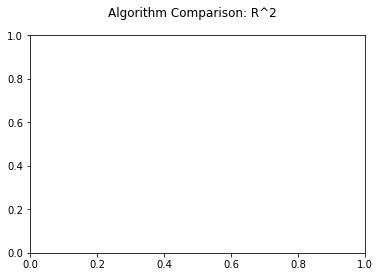

In [192]:
compare_models(train_X, train_y, test_X, test_y, models)

About LASSO:
It's not impossible to get an R^2 value less than 0.
R^2 is a metric used to measure the performance of a regressor. The optimal score of R^2 metric is 1. If any regressor predicts a constant value, you should expect an R^2 score of 0 for that regressor. **But unexpectedly, you can get worse performance than that.**

## Optimization 

In [184]:
models_opt = []

#### Linear Regression: Has to hyperparameters to optimize.

In [185]:
LR = LinearRegression()
models_opt.append(('LD*',LR))

#### Ridge Regression

In [135]:
%%time
Ridge_ = GridSearchCV(Ridge(), param_grid = {'alpha':[i for i in np.arange(0,1,0.01)],\
                                                'solver':('svd', 'cholesky', 'lsqr')},cv=10)
Ridge_.fit(train_X,train_y)

Wall time: 4.79 s


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                   0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13,
                                   0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2,
                                   0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27,
                                   0.28, 0.29, ...],
                         'solver': ('svd', 'cholesky', 'lsqr')})

In [186]:
Ridge_opt = Ridge_.best_estimator_
models_opt.append(('RD*',Ridge_opt))

In [137]:
models_opt

[('LD*', LinearRegression()),
 ('RD*', Ridge(alpha=0.35000000000000003, solver='svd'))]

#### Lasso Regression

In [177]:
%%time
Lasso_ = GridSearchCV(Lasso(), param_grid = {'alpha':[0.0001, 0.0002,0.001,0.01,0.1,0.2,0.5,0.8,1],\
                                            'max_iter':[k for k in np.arange(1000,10000,500)],
                                            'tol':[1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]},cv=10)
Lasso_.fit(train_X,train_y)

Wall time: 13.2 s


GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.0002, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5,
                                   0.8, 1],
                         'max_iter': [1000, 1500, 2000, 2500, 3000, 3500, 4000,
                                      4500, 5000, 5500, 6000, 6500, 7000, 7500,
                                      8000, 8500, 9000, 9500],
                         'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07,
                                 1e-08]})

In [187]:
Lasso_opt = Lasso_.best_estimator_
models_opt.append(('LAS*',Lasso_opt))


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LD*: 0.521027 (0.112379)
RD*: 0.521074 (0.111340)
LAS*: 0.521033 (0.111738)


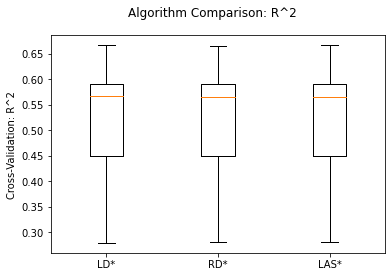

In [188]:
compare_models(train_X, train_y, test_X, test_y, models_opt)

Παρατηρούμε ότι στις περιπτώσεις Ridge&Lasso Regression το γεγονός ότι $\alpha\rightarrow 0$, σημαίνει ότι το πρόβλημά μας τείνει σε αυτό της απλής γραμμικής παλινδρόμησης επομένως παίρνουμε τους ίδιους συντελεστές με αυτό, γιαυτό και οι 2 τιμές του $R^2$ συγκλίνουν προς αυτό της γραμμικής παλινδρόμησης.

#### Decision Trees Regressor